This project explores models to forcast rent prices. A more detailed 
explanation as well as the CSV file used for analalysis and a detailed report 
of the findings can be found on github at the following link: 
https://github.com/arwhit/rental_price_modeling

In [ ]:
#Import Libraries
import pandas as pd
import numpy as np
import math
import datetime
from scipy import stats
import matplotlib as plt
import seaborn as sns

In [ ]:
#Import Data
#Note: CSV was downloaded from Zillow ZORI repository on 11/15/2022
url="https://raw.githubusercontent.com/arwhit/rental_price_modeling/main/Metro_zori_15NOV22.csv"
ZORI_data=pd.read_csv(url)

In [ ]:
#Clean/Transform Data ZORI Data

#remove the US average as it is not meaningful to the metro area analysis
rent_data=ZORI_data.drop(0)
#remove data from the months at the end that are past the last evaluation dates
rent_data=rent_data.drop(columns=[rent_data.columns[94], rent_data.columns[95], rent_data.columns[96]])
#remove data from months at the beggining that are before the measured period
rent_data=rent_data.drop(columns=[rent_data.columns[5], rent_data.columns[6]])
#Remove Unused Non Numeric Data
rent_data=rent_data.drop(columns=["RegionID","SizeRank","RegionType","StateName"])
#remove cities if they are missing more than 5% of measurements
rent_data=rent_data.dropna(thresh=84)

#reset df index to avoid errors
rent_data=rent_data.reset_index(drop=True)

#number of cities ommitted due to too many missing data points
dat_drop_count=len(ZORI_data)-len(rent_data)

#For the reamining metro areas, fill in missing values by averaging the previous and post months rent
replaced_info=[] #[replaced value, row replaced in]
problem_areas=[] 
for i in range(len(rent_data)):
  for j in range(1,len(rent_data.columns)):
    #case if missing value is at the beggining
    if j==1:
      if pd.isnull(rent_data.iloc[i,j]):
        rent_data.iloc[i,j]==rent_data.iloc[i,(j+1)]
        if pd.isnull(rent_data.iloc[i,j]) and i not in problem_areas:
          problem_areas.append(i)
      replaced_info.append([rent_data.iloc[i,j],i])
    #case if missing data point is at the end
    elif j==(len(rent_data.columns)-1):
      if pd.isnull(rent_data.iloc[i,j]):
        rent_data.iloc[i,j]==rent_data.iloc[i,(j-1)]
        if pd.isnull(rent_data.iloc[i,j]) and i not in problem_areas:
          problem_areas.append(i)
        replaced_info.append([rent_data.iloc[i,j],i])
    #case if missing data point in not at the begining or end
    else:
      if pd.isnull(rent_data.iloc[i,j]):
        rent_data.iloc[i,j]==(rent_data.iloc[i,(j-1)]+rent_data.iloc[i,(j+1)])/2
        if pd.isnull(rent_data.iloc[i,j]) and i not in problem_areas:
          problem_areas.append(i)
        replaced_info.append([rent_data.iloc[i,j],i])

#the remaining NaN values are due to two consecutive months of unreported rent data
#these will also be ommited
rent_data=rent_data.drop(problem_areas)
rent_data=rent_data.reset_index(drop=True)

In [ ]:
#Other Data from clean/transform step Neccesary for report

cons_drop_count=len(problem_areas) #number of rows dropped for missing consecutive data

#Calculate number of replaced nans still in dataframe
replaced_nans=0
for lst in replaced_info:
  if lst[1] not in problem_areas:
    replaced_nans+=1

#Total Data Points
tdp=len(rent_data)*(len(rent_data.columns)-1)

In [ ]:
#Warehouse Data in a way condusive to data modeling and pattern evaluation

#create list of column headers to extract dates
column_lst=list(rent_data.columns)

#create empty lists to copy over information
Metro=[]
Date=[]
Rent=[]

for i in range(len(rent_data)):
  for j in range(1,len(rent_data.columns)):
    #Copy Metro Area to list
    Metro.append(rent_data.iloc[i,0])
    #Convert the date into a datetime object and copy to list
    Date.append(datetime.datetime.strptime(column_lst[j],'%Y-%m-%d'))
    #Copy Average Rent to List
    Rent.append(rent_data.iloc[i,j])

#Create new dataframe
wh_data=pd.DataFrame(
    {"Metro":Metro,
     "Date":Date,
     "Rent":Rent}
)

wh_data.head()

,Metro,Date,Rent
0,"Chicago, IL",2015-05-31,1447.457061
1,"Chicago, IL",2015-06-30,1471.120201
2,"Chicago, IL",2015-07-31,1477.492074
3,"Chicago, IL",2015-08-31,1483.756181
4,"Chicago, IL",2015-09-30,1481.774141


In [ ]:
from numpy.lib.function_base import average
#Data Proccessing and Pattern Evaluation

#Prep Model Dates and Create Necessary Lists
max_input_dates=[datetime.datetime.strptime('2015-08-31','%Y-%m-%d'),
                datetime.datetime.strptime('2016-08-31','%Y-%m-%d'),
                datetime.datetime.strptime('2017-08-31','%Y-%m-%d'),
                datetime.datetime.strptime('2018-08-31','%Y-%m-%d'),
                datetime.datetime.strptime('2019-08-31','%Y-%m-%d'),
                datetime.datetime.strptime('2020-08-31','%Y-%m-%d'),
                datetime.datetime.strptime('2021-08-31','%Y-%m-%d')]

prediction_dates=[datetime.datetime.strptime('2016-07-31','%Y-%m-%d'),
                 datetime.datetime.strptime('2017-07-31','%Y-%m-%d'),
                 datetime.datetime.strptime('2018-07-31','%Y-%m-%d'),
                 datetime.datetime.strptime('2019-07-31','%Y-%m-%d'),
                 datetime.datetime.strptime('2020-07-31','%Y-%m-%d'),
                 datetime.datetime.strptime('2021-07-31','%Y-%m-%d'),
                 datetime.datetime.strptime('2022-07-31','%Y-%m-%d')]

#create ndarray of metro areas and convert to list
metro_lst=wh_data["Metro"].unique().tolist()

#create lists to append data
Pred_Year=[]
city=[]
model_type=[]
actual_rent=[]
model_rent=[]
model_pd=[]
p_values=[]
R2_values=[]

#create counter to track high p-values
high_p=0
metro_high_p={}
p_year={2016:[0,0],
        2017:[0,0],
        2018:[0,0],
        2019:[0,0],
        2020:[0,0],
        2021:[0,0],
        2022:[0,0]}
#run calculations by metro area
first_time=True
for metro in metro_lst:
  for i in range(len(prediction_dates)):
    yr=i+2016
    #set date filter criteria
    max_input=max_input_dates[i]
    pred_date=prediction_dates[i]
    #copy over actual rent value to list
    actual=int(wh_data.query("Metro==@metro & Date == @pred_date")["Rent"])
    #create temporary df for prediction calculations
    temp_df=wh_data.query("Metro==@metro & Date <= @max_input")
    #copy over dates and rents to lists
    dates=temp_df["Date"].tolist()
    rents=temp_df["Rent"].tolist()
    #calculate traditional average (avg_rent)
    summer_rents=rents[-4:-1]
    avg=average(summer_rents)
    Pred_Year.append(yr)
    city.append(metro)
    model_type.append("Traditional")
    actual_rent.append(actual)
    model_rent.append(avg)
    model_pd.append(100*(avg-actual)/actual)
    p_values.append(None)
    R2_values.append(None)

    #Convert date time objects to number of days for lm
    numeric_dates=[]
    start_date=dates[0]
    num_max_input=(max_input-start_date).days
    num_pred_date=(pred_date-start_date).days
    for date in dates:
      num_date=(date-start_date).days
      numeric_dates.append(num_date)

    #calculate rolling linear model (lm1), p-value, and R2 value
    lm1=stats.linregress(numeric_dates,rents)
    lm1_pred=lm1.intercept+lm1.slope*num_pred_date
    Pred_Year.append(yr)
    city.append(metro)
    model_type.append("lm1")
    actual_rent.append(actual)
    model_rent.append(lm1_pred)
    model_pd.append(100*(lm1_pred-actual)/actual)
    p_values.append(lm1.pvalue)
    if lm1.pvalue>0.05:
      high_p+=1
      p_year[2016+i][0]+=1
    R2=lm1.rvalue**2
    R2_values.append(R2)

    #calculate annual linear model (lm2), p-value, and R2 value
    min_start_date=num_max_input-365
    for j in range(len(numeric_dates)):
      #remove dates from previous years
      if numeric_dates[j]<min_start_date:
        numeric_dates[j]=None
        rents[j]=None
    numeric_dates=list(filter(lambda x: x is not None, numeric_dates))
    rents=list(filter(lambda x: x is not None, rents))
    #rescale for intercept to be first point
    setpoint=numeric_dates[0]
    for k in range(len(numeric_dates)):
      numeric_dates[k]=numeric_dates[k]-setpoint
    lm2=stats.linregress(numeric_dates,rents)
    lm2_pred=lm2.intercept+lm2.slope*(num_pred_date-setpoint)
    Pred_Year.append(yr)
    city.append(metro)
    model_type.append("lm2")
    actual_rent.append(actual)
    model_rent.append(lm2_pred)
    model_pd.append(100*(lm2_pred-actual)/actual)
    p_values.append(lm2.pvalue)
    if lm2.pvalue>0.05:
      high_p+=1
      p_year[2016+i][1]+=1
    R2=lm2.rvalue**2
    R2_values.append(R2)
#create dataframe with results for pattern analysis
results=pd.DataFrame(
    {"Pred_Year":Pred_Year,
     "Metro":city,
     "Model_type":model_type,
     "Actual_Rent":actual_rent,
     "Model_Rent": model_rent,
     "Model_pd":model_pd,
     "p_values":p_values,
     "R2_values":R2_values}
)

In [ ]:
#analyze overall results
res_summary=results[["Model_type","Model_pd"]].groupby("Model_type").describe()
#calculate 95% confidence interval
CI=[]
for i in range(3):
  lower=res_summary.iloc[i,1]-1.96*(res_summary.iloc[i,2]/math.sqrt(res_summary.iloc[i,0]))
  upper=res_summary.iloc[i,1]+1.96*(res_summary.iloc[i,2]/math.sqrt(res_summary.iloc[i,0]))
  CI.append([lower, upper])

CI  

[[-6.413206628129341, -5.9423515751654605],
 [-3.804377414891535, -3.1888863216870975],
 [-1.379456126851146, -0.8876642619201264]]

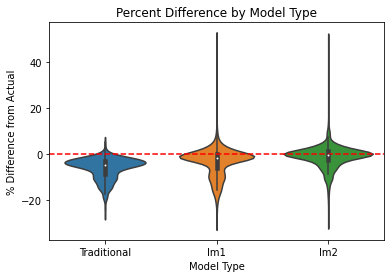

In [ ]:
#Violin plot of percent difference
vp=sns.violinplot(data=results, x="Model_type", y="Model_pd")
vp.set(xlabel='Model Type', ylabel='% Difference from Actual', title='Percent Difference by Model Type')
vp.axhline(0, color="red", linestyle="--")

In [ ]:
#analyze results by year
year_summary=results[["Pred_Year","Model_type","Model_pd"]].groupby(["Pred_Year","Model_type"]).describe()

#calculate 95% CI by year
CI_Lower=[]
CI_Upper=[]
for i in range(len(year_summary)):
  lower=year_summary.iloc[i,1]-1.96*(year_summary.iloc[i,2]/math.sqrt(year_summary.iloc[i,0]))
  upper=year_summary.iloc[i,1]+1.96*(year_summary.iloc[i,2]/math.sqrt(year_summary.iloc[i,0]))
  CI_Lower.append(lower)
  CI_Upper.append(upper)

#Add to DF and remove unwanted columns
year_summary["Lower"]=CI_Lower
year_summary["Upper"]=CI_Upper
year_summary

Model_pd                                             \
                         count       mean       std        min        25%   
Pred_Year Model_type                                                        
2016      Traditional    215.0  -3.814898  2.836375 -13.083591  -5.167269   
          lm1            215.0   0.912653  6.588498 -30.271930  -1.209870   
          lm2            215.0   0.912653  6.588498 -30.271930  -1.209870   
2017      Traditional    215.0  -3.905268  2.293255 -10.914526  -5.198834   
          lm1            215.0  -0.679609  1.687274  -7.326066  -1.551775   
          lm2            215.0   0.251796  2.382787  -6.297672  -0.994378   
2018      Traditional    215.0  -3.930000  2.021712 -10.598378  -5.219260   
          lm1            215.0  -0.982039  1.827575  -5.167351  -2.020454   
          lm2            215.0   0.027663  1.742649  -4.901146  -0.910307   
2019      Traditional    215.0  -4.416030  2.308964 -22.902764  -5.506344   
          lm1            215.0  -1.591375  2.543732 -20.889484  -2.630102   
          lm2            215.0  -0.422544  2.232351 -17.319125  -1.356181   
2020      Traditional    215.0  -3.262567  2.166789 -14.804818  -4.430186   
          lm1            215.0  -0.644242  2.588579  -9.947943  -2.288387   
          lm2            215.0   1.193780  3.400446 -17.653156  -0.107435   
2021      Traditional    215.0 -11.339448  4.119522 -26.326426 -13.799508   
          lm1            215.0  -8.211981  4.231526 -22.388173 -10.610500   
          lm2            215.0  -7.894172  4.004531 -22.057176 -10.611656   
2022      Traditional    215.0 -12.576242  3.576183 -26.358581 -14.689373   
          lm1            215.0 -13.279830  3.989037 -25.379113 -16.038964   
          lm2            215.0  -2.004097  4.653397 -14.612530  -4.921595   

                                                            Lower      Upper  
                             50%        75%        max                        
Pred_Year Model_type                                                          
2016      Traditional  -3.430117  -2.086756   5.206995  -4.194039  -3.435757  
          lm1           1.294480   3.312792  50.151653   0.031962   1.793343  
          lm2           1.294480   3.312792  50.151653   0.031962   1.793343  
2017      Traditional  -3.573835  -2.222657   3.033051  -4.211810  -3.598727  
          lm1          -0.839227  -0.084488   8.725522  -0.905148  -0.454069  
          lm2          -0.003949   1.046178  14.741178  -0.066713   0.570305  
2018      Traditional  -3.804109  -2.521467   2.985082  -4.200244  -3.659756  
          lm1          -1.199255  -0.199733   6.547640  -1.226332  -0.737745  
          lm2           0.111157   0.899480  10.303925  -0.205279   0.260604  
2019      Traditional  -4.452566  -3.186004   4.633061  -4.724671  -4.107388  
          lm1          -1.750070  -0.561761  10.647666  -1.931398  -1.251352  
          lm2          -0.398713   0.691769   8.113424  -0.720944  -0.124143  
2020      Traditional  -3.384443  -1.885078   4.940684  -3.552204  -2.972930  
          lm1          -0.658376   1.193548   7.600020  -0.990260  -0.298224  
          lm2           0.921611   2.354274  32.882933   0.739239   1.648320  
2021      Traditional -11.087710  -8.591403   0.900704 -11.890109 -10.788788  
          lm1          -8.148392  -5.457709   5.621193  -8.777613  -7.646349  
          lm2          -7.429653  -5.033494   0.111017  -8.429462  -7.358883  
2022      Traditional -12.107229 -10.362970  -4.688806 -13.054274 -12.098210  
          lm1         -13.114392 -10.394905  -2.781757 -13.813049 -12.746612  
          lm2          -2.377591   0.248442  18.472209  -2.626120  -1.382073

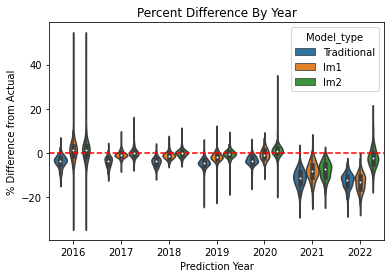

In [ ]:
vplot=sns.violinplot(data=results, x="Pred_Year", y="Model_pd", hue="Model_type")
vplot.set(xlabel='Prediction Year', ylabel='% Difference from Actual', title='Percent Difference By Year')
vplot.axhline(0, color="red", linestyle="--")

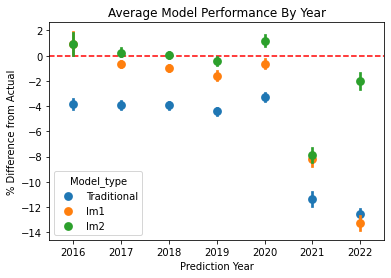

In [ ]:
#plot of average percent difference by prediction year with CI
pd_plot=sns.pointplot(data=results, x="Pred_Year", y="Model_pd", hue="Model_type",join=False)
pd_plot.set(xlabel='Prediction Year', ylabel='% Difference from Actual', title='Average Model Performance By Year')
pd_plot.axhline(0, color="red", linestyle="--")

In [ ]:
#Analyze p and R^2 values
lm_data=results[(results.Model_type=="lm1")|(results.Model_type=="lm2")]
lm_summary=lm_data[["Model_type","p_values","R2_values"]].groupby("Model_type").describe()
lm_summary

p_values                                                  \
              count      mean       std           min           25%   
Model_type                                                            
lm1          1505.0  0.032847  0.120996  1.843201e-74  7.765055e-38   
lm2          1505.0  0.047975  0.144306  8.119704e-14  2.425432e-06   

                                             R2_values                     \
                     50%       75%       max     count     mean       std   
Model_type                                                                  
lm1         1.017159e-20  0.000008  0.988433    1505.0  0.82439  0.224691   
lm2         9.681990e-05  0.009380  0.988433    1505.0  0.73385  0.241269   

                                                              
                 min       25%       50%       75%       max  
Model_type                                                    
lm1         0.000083  0.793541  0.917989  0.962187  0.999743  
lm2         0.000058  0.642330  0.813808  0.905583  0.999743

In [ ]:
p_summary=lm_data[["Pred_Year","Model_type","p_values"]].groupby(["Pred_Year","Model_type"]).describe()
p_summary

p_values                                                  \
                        count      mean       std           min           25%   
Pred_Year Model_type                                                            
2016      lm1           215.0  0.161201  0.218879  1.284491e-04  1.893614e-02   
          lm2           215.0  0.161201  0.218879  1.284491e-04  1.893614e-02   
2017      lm1           215.0  0.028476  0.107699  1.248955e-15  3.399657e-08   
          lm2           215.0  0.041693  0.132872  3.843242e-12  4.418848e-06   
2018      lm1           215.0  0.018354  0.103739  8.864841e-28  2.272080e-17   
          lm2           215.0  0.037431  0.140912  8.119704e-14  3.654039e-06   
2019      lm1           215.0  0.005686  0.049285  6.015041e-46  1.003952e-28   
          lm2           215.0  0.019746  0.100623  1.750796e-12  9.339049e-07   
2020      lm1           215.0  0.008151  0.076162  7.995037e-60  5.456122e-41   
          lm2           215.0  0.016539  0.090647  1.423141e-11  7.690338e-07   
2021      lm1           215.0  0.007661  0.067281  2.516859e-72  3.404308e-53   
          lm2           215.0  0.057977  0.159115  3.843860e-09  1.723184e-05   
2022      lm1           215.0  0.000398  0.005842  1.843201e-74  3.214613e-50   
          lm2           215.0  0.001236  0.012467  8.454907e-12  1.326925e-07   

                                                            
                               50%           75%       max  
Pred_Year Model_type                                        
2016      lm1         6.157771e-02  2.010225e-01  0.988433  
          lm2         6.157771e-02  2.010225e-01  0.988433  
2017      lm1         1.136766e-05  1.207764e-03  0.927965  
          lm2         1.083153e-04  4.132630e-03  0.900232  
2018      lm1         5.170437e-13  3.285219e-09  0.963342  
          lm2         7.781896e-05  2.353936e-03  0.966760  
2019      lm1         1.510286e-23  9.270838e-18  0.574384  
          lm2         2.937891e-05  1.012165e-03  0.980216  
2020      lm1         2.091812e-34  2.686643e-27  0.843123  
          lm2         1.692463e-05  2.354369e-04  0.884698  
2021      lm1         1.789061e-46  1.028985e-36  0.885790  
          lm2         4.385789e-04  1.237036e-02  0.931831  
2022      lm1         1.208152e-42  5.977545e-33  0.085659  
          lm2         2.358025e-06  3.556560e-05  0.180608

In [ ]:
#number of models where predictor is not statistically significant
p_year

{2016: [117, 117],
 2017: [21, 29],
 2018: [12, 17],
 2019: [4, 15],
 2020: [3, 11],
 2021: [4, 40],
 2022: [1, 1]}

[Text(0, 0.5, 'Average P Value'),
 Text(0.5, 0, 'Prediction Year'),
 Text(0.5, 1.0, 'Average Parameter P Value By Year')]

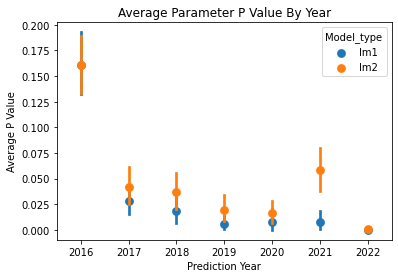

In [ ]:
#Visualization of p-values of the 2 different linear models by year
p_plot=sns.pointplot(data=lm_data, x="Pred_Year", y="p_values", hue="Model_type",join=False)
p_plot.set(xlabel='Prediction Year', ylabel='Average P Value', title='Average Parameter P Value By Year')

In [ ]:
R2_summary=lm_data[["Pred_Year","Model_type","R2_values"]].groupby(["Pred_Year","Model_type"]).describe()
R2_summary

R2_values                                          \
                         count      mean       std       min       25%   
Pred_Year Model_type                                                     
2016      lm1            215.0  0.751269  0.283987  0.000134  0.638371   
          lm2            215.0  0.751269  0.283987  0.000134  0.638371   
2017      lm1            215.0  0.677754  0.256231  0.000605  0.538758   
          lm2            215.0  0.697496  0.259953  0.001651  0.577438   
2018      lm1            215.0  0.788650  0.234009  0.000083  0.745893   
          lm2            215.0  0.696520  0.240586  0.000165  0.584015   
2019      lm1            215.0  0.859982  0.190412  0.008375  0.859434   
          lm2            215.0  0.736166  0.216120  0.000058  0.640781   
2020      lm1            215.0  0.894788  0.172903  0.000791  0.905745   
          lm2            215.0  0.770196  0.200381  0.001999  0.722081   
2021      lm1            215.0  0.916177  0.158985  0.000335  0.925747   
          lm2            215.0  0.637127  0.275104  0.000769  0.481403   
2022      lm1            215.0  0.882109  0.126512  0.039393  0.856773   
          lm2            215.0  0.848180  0.116449  0.156688  0.801358   

                                                    
                           50%       75%       max  
Pred_Year Model_type                                
2016      lm1         0.880636  0.962486  0.999743  
          lm2         0.880636  0.962486  0.999743  
2017      lm1         0.758313  0.893584  0.990718  
          lm2         0.790896  0.888680  0.993106  
2018      lm1         0.869678  0.939632  0.990424  
          lm2         0.771598  0.867866  0.994580  
2019      lm1         0.930016  0.962600  0.995357  
          lm2         0.808012  0.896672  0.990529  
2020      lm1         0.950978  0.973259  0.995279  
          lm2         0.826042  0.900224  0.986142  
2021      lm1         0.964012  0.978150  0.994722  
          lm2         0.725323  0.854319  0.972601  
2022      lm1         0.921555  0.951028  0.989159  
          lm2         0.877875  0.927324  0.987393

[Text(0, 0.5, 'R^2 Value'),
 Text(0.5, 0, 'Prediction Year'),
 Text(0.5, 1.0, 'Average R^2 Value By Year')]

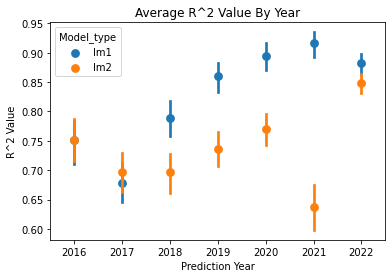

In [ ]:
#Visualization of R^2 values of the 2 linear models
R2_plot=sns.pointplot(data=lm_data, x="Pred_Year", y="R2_values", hue="Model_type",join=False)
R2_plot.set(xlabel='Prediction Year', ylabel='R^2 Value', title='Average R^2 Value By Year')

[Text(0, 0.5, 'Average Rent'),
 Text(0.5, 0, 'Year'),
 Text(0.5, 1.0, 'Average Rent in the US By Year')]

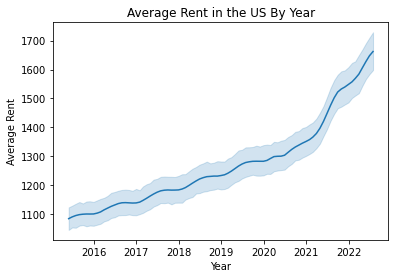

In [ ]:
#General Rent Trends
#rent_trends=wh_data.groupby("Date")
rent_plot=sns.lineplot(data=wh_data, x="Date", y="Rent")
rent_plot.set(xlabel='Year', ylabel='Average Rent', title='Average Rent in the US By Year')

In [ ]:
wh_data["Rent"].mean()

1272.7859659375695